In [38]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
from matplotlib import pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!


sns.set() # better looking figs



In [3]:
df = pd.read_csv("questionnaire-answers-per-clip.csv")
df

,Unnamed: 0,clipName,pptID,condition,gettingOnWell,relationshipBetweenCharacters,workingTogether,leftDominant,rightDominant,leftCooperative,...,leftFearful,rightFearful,leftSad,rightSad,leftContent,rightContent,leftAngry,rightAngry,leftAmused,rightAmused
0,0,1Laugh1PushAway,55,4,0.0,0.0,0.0,4.0,4.0,4.0,...,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
1,1,1Laugh1PushAway,87,4,1.0,0.0,2.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.0
2,2,1Laugh1PushAway,118,2,0.0,0.0,0.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
3,3,1Laugh1PushAway,136,2,2.0,0.0,2.0,1.0,3.0,1.0,...,2.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0
4,4,1Laugh1PushAway,417,4,2.0,2.0,2.0,2.0,3.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0
5,5,1Laugh1PushAway,681,4,1.0,1.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,4.0,2.0
6,6,1Laugh1PushAway,695,4,0.0,0.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
7,7,1Laugh1PushAway,1031,4,2.0,2.0,2.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,3.0,1.0
8,8,1Laugh1PushAway,1315,4,1.0,0.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0
9,9,1Laugh1PushAway,1460,2,0.0,0.0,0.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0


## PCA for dimensionality reduction

In [4]:
from sklearn.decomposition import PCA

In [5]:
skel_df=df[df["condition"]==2] # skeleton only
skel=skel_df.T.iloc[4:].T.values
skel_means=skel_df.groupby(["clipName"]).mean().T.iloc[3:].T
skel_labels=skel_df["clipName"].values

fullscene_df=df[df["condition"]==4] # full scene
fullscene=fullscene_df.T.iloc[4:].T.values
fullscene_means=fullscene_df.groupby(["clipName"]).mean().T.iloc[3:].T
fullscene_labels=fullscene_df["clipName"].values

In [6]:
pca=PCA(n_components=6)
pca.fit(skel)

skel_pca = pca.transform(skel)
skel_means_pca = pca.transform(skel_means.values)

fullscene_pca = pca.transform(fullscene)
fullscene_means_pca = pca.transform(fullscene_means.values)

## Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')
    
def plot_embedding(X, labels, means=None, means_labels=None, three_d=False):

    plt.figure()
    
    colors = [list(set(labels)).index(l) for l in labels]
    if means_labels is not None:
        colors_means = [sns.color_palette("tab20",20)[list(set(labels)).index(l)] for l in means_labels]
    
    handles=[]
    if three_d:
        ax = plt.subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:,2], marker="o", c=colors, label=labels, cmap=plt.get_cmap("tab20"))
        ax.set_zlabel('3rd component')
        
        if means is not None:
            for i in range(means.shape[0]):
                points=ax.scatter(means[i, 0], means[i, 1], means[i,2], marker="o", s=200, c=colors_means[i], label=means_labels[i])
                handles.append(points)
            
    else:
        ax = plt.subplot(111)
        ax.scatter(X[:, 0], X[:, 1], marker="o", c=colors, label=labels[:], cmap=plt.get_cmap("tab20"))
        
        if means is not None:
            for i in range(means.shape[0]):
                points=ax.scatter(means[i, 0], means[i, 1], marker="o", s=200, c=colors_means[i], label=means_labels[i])
                handles.append(points)
            

    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')

    if means is not None:
        ax.legend(handles, means_labels, loc=1, prop=fontP)
        
def plot_compare_embeddings(X, Y, labels, three_d=False):

    plt.figure()
    
    colors = [sns.color_palette("tab20",20)[list(labels).index(l)] for l in labels]
    
    handles=[]
    
    if three_d:
        ax = plt.subplot(111, projection='3d')
        
        for i in range(X.shape[0]):
            points=ax.scatter(X[i, 0], X[i, 1], X[i,2], marker="o", s=200, c=colors[i], label=labels[i])
            handles.append(points)
            points=ax.scatter(Y[i, 0], Y[i, 1], Y[i,2], marker="x", s=200, c=colors[i], label=labels[i])
            
            ax.plot((X[i,0], Y[i,0]), (X[i,1], Y[i,1]), (X[i,2], Y[i,2]), '-',c=colors[i])
            
        ax.set_zlabel('3rd component')
        #ax.set_zlim(-3,3)
            
    else:
        ax = plt.subplot(111)
        
        for i in range(X.shape[0]):
            points=ax.scatter(X[i, 0], X[i, 1], marker="o", s=200, c=colors[i], label=labels[i])
            handles.append(points)
            ax.scatter(Y[i, 0], Y[i, 1], marker="x", s=200, c=colors[i], label=labels[i])
            
            ax.plot((X[i,0], Y[i,0]), (X[i,1], Y[i,1]), '-',c=colors[i])
                       

    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    
    #ax.set_xlim(-3,3)
    #ax.set_ylim(-3,3)
    

    ax.legend(handles, labels, loc='best', prop=fontP)
    ax.set_title("O: skel (skeletons), X: fullscene (full scene)")
    

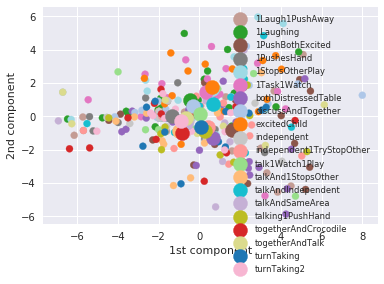

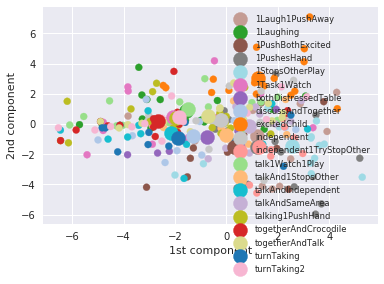

In [8]:
plot_embedding(skel_pca, skel_labels, skel_means_pca, skel_means.index, three_d=False) 
plot_embedding(fullscene_pca, fullscene_labels, fullscene_means_pca, fullscene_means.index, three_d=False)

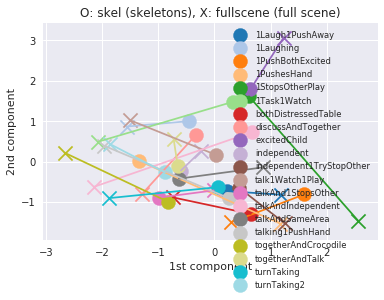

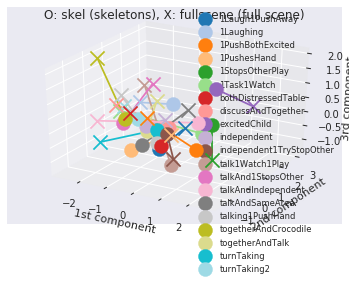

In [9]:
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index,three_d=False)
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index,three_d=True)

In [10]:
distances_pca=pd.DataFrame(np.power(np.sum(np.power(skel_means_pca - fullscene_means_pca, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_pca"])
distances_pca

,distance_pca
clipName,
1Laugh1PushAway,1.627761
1Laughing,1.352605
1PushBothExcited,2.132483
1PushesHand,3.407838
1StopsOtherPlay,3.773486
1Task1Watch,2.934082
bothDistressedTable,2.335876
discussAndTogether,2.395046
excitedChild,1.798807


In [11]:
pca.explained_variance_ratio_.cumsum()

array([0.28405715, 0.41658333, 0.51708521, 0.57579546, 0.62923102,
       0.67070969])

In [12]:
pca.components_


array([[ 0.17548592,  0.15016615,  0.14538466,  0.05376097,  0.13633354,
        -0.21093684, -0.2386643 ,  0.17641636,  0.23302474, -0.21699709,
        -0.25971502,  0.19025137,  0.27863681, -0.15274028, -0.11062468,
         0.20882575,  0.18131997,  0.18626668,  0.16037721, -0.23449424,
        -0.24284952,  0.2457872 ,  0.30775015, -0.14672371, -0.16033606],
       [ 0.01357949,  0.01438256,  0.02452207,  0.42994249, -0.41896846,
        -0.18209335,  0.0747369 ,  0.32136526, -0.2173944 , -0.13951877,
         0.07173952,  0.3495939 , -0.24967575,  0.0014334 , -0.1105479 ,
        -0.21517212,  0.26782144, -0.12600513,  0.1804615 ,  0.07111757,
        -0.04827713,  0.15283523, -0.13380643,  0.10641266,  0.03883441],
       [-0.14391971, -0.11048205, -0.18594399,  0.05503047,  0.2185336 ,
         0.13508949,  0.12723342,  0.30134902,  0.27324022,  0.21053698,
         0.21047521,  0.22557171,  0.28653153,  0.08431671,  0.12230118,
         0.19236272,  0.16733776,  0.12434086,  0

## LDA

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [14]:
lda = LinearDiscriminantAnalysis(n_components=4)
lda.fit(skel_pca, skel_labels)

# we perform the LDA *on top of the PCA* as LDA typically requires O > 3 F, with O the nb of observations and F the nb of features (here, we have ~26 observations for originally 25 questions)
skel_lda = lda.transform(pca.transform(skel))
skel_means_lda = lda.transform(pca.transform(skel_means.values))

fullscene_lda = lda.transform(pca.transform(fullscene))
fullscene_means_lda = lda.transform(pca.transform(fullscene_means.values))


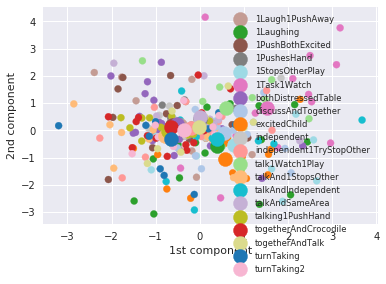

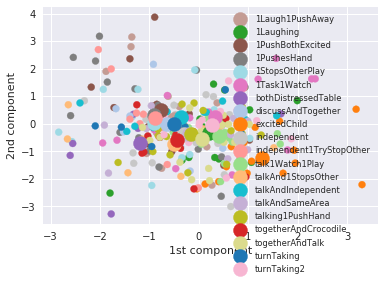

In [15]:
plot_embedding(skel_lda, skel_labels,skel_means_lda, skel_means.index, three_d=False)
plot_embedding(fullscene_lda, fullscene_labels,fullscene_means_lda, fullscene_means.index, three_d=False)

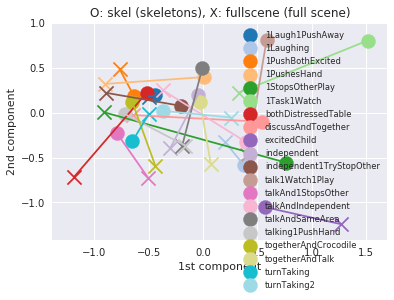

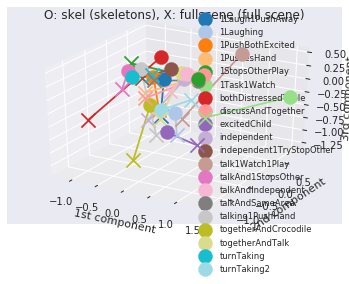

In [16]:
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=False)
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=True)

In [17]:
distances_lda=pd.DataFrame(np.power(np.sum(np.power(skel_means_lda - fullscene_means_lda, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_lda"])


In [18]:
distances = pd.concat([distances_pca, distances_lda], axis=1)
s = distances.style.background_gradient(cmap="summer")
s


,distance_pca,distance_lda
clipName,,
1Laugh1PushAway,1.62776,0.789445
1Laughing,1.3526,0.698463
1PushBothExcited,2.13248,1.169
1PushesHand,3.40784,1.15119
1StopsOtherPlay,3.77349,1.86058
1Task1Watch,2.93408,1.37355
bothDistressedTable,2.33588,1.5393
discussAndTogether,2.39505,1.40226
excitedChild,1.79881,0.724966


## Explorative Factor Analysis

In [19]:
import factor_analyzer


In [20]:
skel_factor_df=skel_df.T.iloc[4:].T.astype(float)

fa_skel = factor_analyzer.FactorAnalyzer()
fa_skel.analyze(skel_factor_df,6,rotation='varimax')
skel_loadings=fa_skel.loadings

fullscene_factor_df=fullscene_df.T.iloc[4:].T.astype(float)

fa_fullscene = factor_analyzer.FactorAnalyzer()
fa_fullscene.analyze(fullscene_factor_df,6,rotation='varimax')
fullscene_loadings=fa_fullscene.loadings

In [21]:
# merge loadings into one dataframe, skel and fullscene side-by-side
loadings=pd.concat([skel_loadings, fullscene_loadings], keys=["skel", "fullscene"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

In [22]:
# helper function for table-wise heatmap
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = matplotlib.colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [matplotlib.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [23]:
styled_loadings = loadings.style.apply(background_gradient,
                     cmap='PuOr',
                     m=loadings.min().min(),
                     M=loadings.max().max(),
                     low=0,
                     high=0.2)

styled_loadings

In [32]:
fa_skel.get_factor_variance()


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,4.277042,2.557872,2.652916,1.534528,1.999144,0.952911
Proportion Var,0.171082,0.102315,0.106117,0.061381,0.079966,0.038116
Cumulative Var,0.171082,0.273397,0.379513,0.440894,0.520860,0.558977


In [34]:
fa_fullscene.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,4.123440,3.828582,1.935570,1.220591,1.878083,1.319507
Proportion Var,0.164938,0.153143,0.077423,0.048824,0.075123,0.052780
Cumulative Var,0.164938,0.318081,0.395504,0.444327,0.519451,0.572231


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f20d9091978>,
      dtype=object)

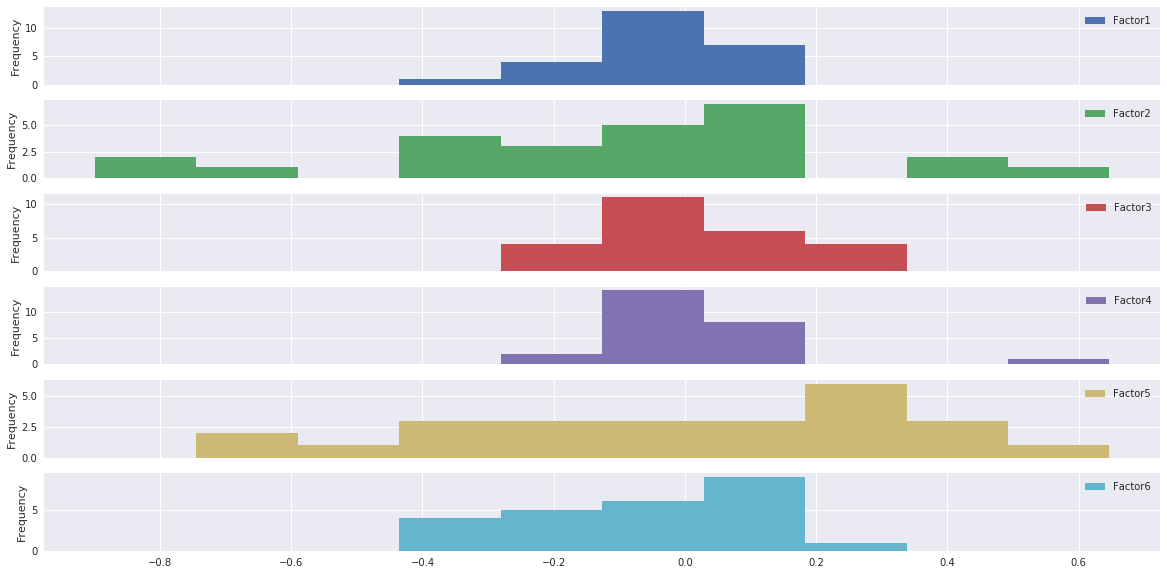

In [67]:
# check for normality of the difference of loadings -> not normal! paired t-test not valid; using Wilcoxon signed-rank test instead
diff=skel_loadings - fullscene_loadings
diff.plot(kind="hist",subplots=True)


In [70]:
for k in diff.columns: print("%s: %s" % (k,stats.ttest_1samp(diff[k])))

TypeError: ttest_1samp() missing 1 required positional argument: 'popmean'

In [ ]:
for k in diff.columns: print("%s: %s" % (k,stats.wilcoxon(diff[k])))

# Classification

In [26]:
from sklearn import svm

In [27]:
clf = svm.SVC(kernel='rbf')

# trying with skel, skel_pca, skel_lda do not lead to any clear improvements
training_set = skel_lda
training_labels = skel_labels

testing_set = fullscene_lda
testing_labels = fullscene_labels

clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))

1PushBothExcited (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
excitedChild (should be 1Laugh1PushAway)
excitedChild (should be 1Laugh1PushAway)
discussAndTogether (should be 1Laugh1PushAway)
1Laughing (should be 1Laugh1PushAway)
bothDistressedTable (should be 1Laugh1PushAway)
1Task1Watch (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
discussAndTogether (should be 1Laughing)
bothDistressedTable (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
discussAndTogether (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
1Laughing (should be 1Laughing)
excitedChild (should be 1Laugh

In [29]:
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

SVM: 10.1% successful prediction out of 276 tested clips


In [30]:
import itertools
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


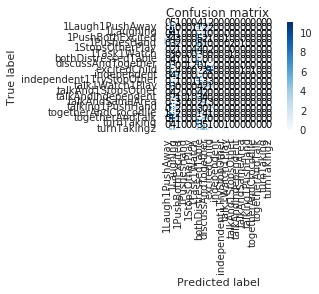

In [31]:
from sklearn.metrics import confusion_matrix


cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))